# **Automatidata project**
**The Nuts and bolts of machine learning**

You are a data professional in a data analytics firm called Automatidata. Their client, the New York City Taxi & Limousine Commission (New York City TLC), was impressed with the work you have done and has requested that you build a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.



# Build a machine learning model

Suppose you were to modify the modeling objective so, instead of predicting people who won't tip at all, you predicted people who are particularly generous&mdash;those who will tip 20% or more? Consider the following questions:

1.  What features do you need to make this prediction?

2.  What would be the target variable?  

3.  What metric should you use to evaluate your model? Do you have enough information to decide this now?


**Responses:**

**Question 1:**  What features do you need to make this prediction?

Ideally, we'd have behavioral history for each customer, so we could know how much they tipped on previous taxi rides. We'd also want times, dates, and locations of both pickups and dropoffs, estimated fares, and payment method.

**Question 2:**  What would be the target variable?


The target variable would be a binary variable (1 or 0) that indicates whether or not the customer is expected to tip ≥ 20%.

**Question 3:**  

This is a supervised learning, classification task. We could use accuracy, precision, recall, F-score, area under the ROC curve, or a number of other metrics. However, we don't have enough information at this time to know which are most appropriate. We need to know the class balance of the target variable.

### **Task 1. Imports and data loading**



In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [67]:
# RUN THIS CELL TO SEE ALL COLUMNS 
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

Begin by reading in the data. There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares from the previous course's project called nyc_preds_means.csv.

In [68]:
# RUN THE CELL BELOW TO IMPORT YOUR DATA. 

# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

Inspect the first few rows of `df0`.


In [69]:
# Inspect the first few rows of df0
df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


Inspect the first few rows of `nyc_preds_means`.

In [70]:
# Inspect the first few rows of `nyc_preds_means`
nyc_preds_means.head()

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642


#### Join the two dataframes

Join the two dataframes using a method of your choice.

In [71]:
# Merge datasets
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


### **Task 2. Feature engineering**

You have already prepared much of this data and performed exploratory data analysis (EDA) in previous courses. 


In [72]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

You know from your EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, you'll need to sample the data to select only the customers who pay with credit card. 

Copy `df0` and assign the result to a variable called `df1`. Then, use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [73]:
# Subset the data to isolate only customers who paid by credit card
df1=df0[df0['payment_type']==1]

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal. **This is an important step.** It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous. 

To understand why, you must consider how floats work. Computers make their calculations using floating-point arithmetic (hence the word "float"). Floating-point arithmetic is a system that allows computers to express both very large numbers and very small numbers with a high degree of precision, encoded in binary. However, precision is limited by the number of bits used to represent a number, which is generally 32 or 64, depending on the capabilities of your operating system. 

This comes with limitations in that sometimes calculations that should result in clean, precise values end up being encoded as very long decimals. Take, for example, the following calculation:


In [74]:
# Run this cell
1.1 + 2.2

3.3000000000000003

In [75]:
# Create tip % col
df1['tip_percent'] = round(df1['tip_amount']/(df1['tip_amount'] - df1['tip_amount']), 3)

Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [76]:
# Create 'generous' col (target)
df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)

In [77]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

In [78]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [79]:
# Create 'am_rush' col
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour

You'll need to write four functions to convert each new column to binary (0/1). Begin with `am_rush`. Complete the function so if the hour is between [06:00–10:00), it returns 1, otherwise, it returns 0.

In [80]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [81]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

Write functions to convert the three remaining columns and apply them to their respective series.

In [82]:
#Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [83]:
# Apply 'daytime' function to the 'daytime' 
df1['daytime'] = df1.apply(daytime, axis=1)

In [84]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [85]:
# Apply 'pm_rush' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [86]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [87]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)

#### Create `month` column

In [88]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

Examine the first five rows of your dataframe.

In [89]:
df1.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245,inf,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218,inf,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706,inf,1,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650,inf,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36,11.855376,2.052258,10.441351,inf,1,saturday,0,0,0,1,mar


#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [90]:
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df1 = df1.drop(drop_cols, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int64  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int64(10), object(2)
memory usage: 1.9+ MB


#### Variable encoding

In [91]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df1[col] = df1[col].astype('str')

Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`.


In [92]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15265 entries, 0 to 22698
Columns: 347 entries, passenger_count to month_sep
dtypes: bool(338), float64(3), int64(6)
memory usage: 6.1 MB


##### Evaluation metric

Before modeling, you must decide on an evaluation metric. 

1. Examine the class balance of your target variable. 

In [93]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)

generous
1    0.959188
0    0.040812
Name: proportion, dtype: float64

### **Task 3. Modeling**

In [94]:
# Isolate target variable (y)
y = df2['generous']

# Isolate the features (X)
X = df2.drop('generous', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [97]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune 
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='f1')

In [98]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 5min 21s, sys: 220 ms, total: 5min 21s
Wall time: 5min 21s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [0.7], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

If you want, use `pickle` to save your models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [99]:
import pickle 

# Define a path to the folder where you want to save the model
path = '/home/jovyan/work/'

In [100]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [101]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

Examine the best average score across all the validation folds. 

In [102]:
# Examine best score
rf1.best_score_

0.978185232958997

Examine the best combination of hyperparameters.

In [103]:
rf1.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [104]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

Call `make_results()` on the GridSearch object.

In [105]:
# Call 'make_results()' on the GridSearch object
results = make_results('RF CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,RF CV,0.959898,0.997183,0.978185,0.957337


Your results should produce an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on your use case. Optional: try to improve the scores. It's worth trying, especially to practice searching over different hyperparameters.

<details>
  <summary><h5>HINT</h5></summary>

For example, if the available values for `min_samples_split` were [2, 3, 4] and GridSearch identified the best value as 4, consider trying [4, 5, 6] this time.
</details>

Use your model to predict on the test data. Assign the results to a variable called `rf_preds`.

<details>
  <summary><h5>HINT</h5></summary>
    
You cannot call `predict()` on the GridSearchCV object directly. You must call it on the `best_estimator_`.
</details>

For this project, you will use several models to predict on the test data. Remember that this decision comes with a trade-off. What is the benefit of this? What is the drawback?

 **response:**

The benefit of using multiple models to predict on the test data is that you can compare models using data that was not used to train/tune hyperparameters. This reduces the risk of selecting a model based on how well it fit the training data.

The drawback of using the final test data to select a model is that, by using the unseen data to make a decision about which model to use, you no longer have a truly unbiased idea of how your model would be expected to perform on new data. In this case, think of final model selection as another way of "tuning" your model.

In [106]:
# Get scores on test data
rf_preds = rf1.best_estimator_.predict(X_test)

Use the below `get_test_scores()` function you will use to output the scores of the model on the test data.

In [107]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `rf_test_scores`.
2. Call `rf_test_scores` to output the results.

###### RF test results

In [108]:
# Get scores on test data
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.959898,0.997183,0.978185,0.957337
0,RF test,0.959593,0.997609,0.978232,0.957419


**Question:** How do your test results compare to your validation results?

**Response:** All scores increased by at most ~0.02.

In [109]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [500]
             }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [110]:
%%time
xgb1.fit(X_train, y_train)

CPU times: user 21.3 s, sys: 104 ms, total: 21.4 s
Wall time: 11.2 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [8],
                         'min_child_weight': [2], 'n_estimators': [500]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

Get the best score from this model.

In [111]:
# Examine best score
xgb1.best_score_

0.977678557349253

And the best parameters.

In [112]:
# Examine best parameters
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 500}

##### XGB CV Results

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [113]:
# Call 'make_results()' on the GridSearch object
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.959898,0.997183,0.978185,0.957337
0,RF test,0.959593,0.997609,0.978232,0.957419
0,XGB CV,0.959556,0.996500,0.977679,0.956354


Use your model to predict on the test data. Assign the results to a variable called `xgb_preds`.

<details>
  <summary><h5>HINT</h5></summary>
    
You cannot call `predict()` on the GridSearchCV object directly. You must call it on the `best_estimator_`.
</details>

In [114]:
# Get scores on test data
xgb_preds = xgb1.best_estimator_.predict(X_test)

###### XGB test results

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_test_scores`.
2. Call `xgb_test_scores` to output the results.

In [115]:
# Get scores on test data
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF CV,0.959898,0.997183,0.978185,0.957337
0,RF test,0.959593,0.997609,0.978232,0.957419
0,XGB CV,0.959556,0.996500,0.977679,0.956354
0,XGB test,0.959304,0.998292,0.978410,0.957746


**Question:** Compare these scores to the random forest test scores. What do you notice? Which model would you choose?

**Response:**
The F1 score is ~0.014 lower than the random forest model. Both models are acceptable, but the random forest model is the champion.

Plot a confusion matrix of the champion model's predictions on the test data.

Plot a confusion matrix of the model's predictions on the test data.

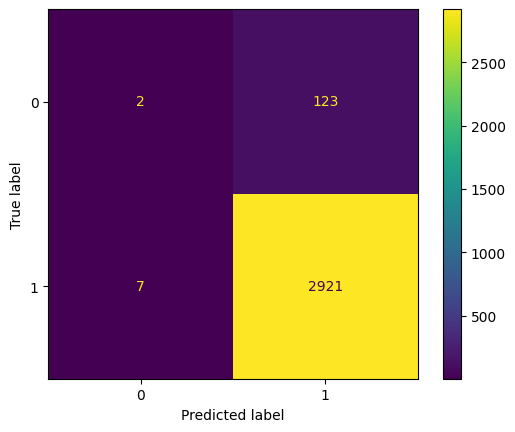

In [116]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_, 
                             )
disp.plot(values_format='');

**Question:** What type of errors are more common for your model?

**Response:**

The model is almost twice as likely to predict a false positive than it is to predict a false negative. Therefore, type I errors are more common. This is less desirable, because it's better for a driver to be pleasantly surprised by a generous tip when they weren't expecting one than to be disappointed by a low tip when they were expecting a generous one. However, the overall performance of this model is satisfactory. 

##### Feature importance

Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones.

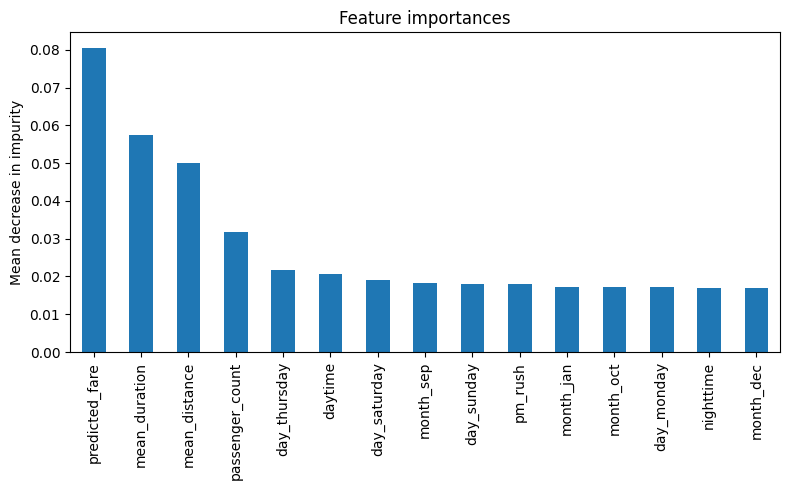

In [117]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

### **Task 4. Conclusion**

In this step, use the results of the models above to formulate a conclusion. Consider the following questions:

**Exemplar responses:**
1. **Would you recommend using this model? Why or why not?**  
Yes, this is model performs acceptably. Its F<sub>1</sub> score was 0.7235 and it had an overall accuracy of 0.6865. It correctly identified ~78% of the actual responders in the test set, which is 48% better than a random guess. It may be worthwhile to test the model with a select group of taxi drivers to get feedback.  


2. **What was your highest scoring model doing? Can you explain how it was making predictions?**   
Unfortunately, random forest is not the most transparent machine learning algorithm. We know that `VendorID`, `predicted_fare`, `mean_duration`, and `mean_distance` are the most important features, but we don't know how they influence tipping. This would require further exploration. It is interesting that `VendorID` is the most predictive feature. This seems to indicate that one of the two vendors tends to attract more generous customers. It may be worth performing statistical tests on the different vendors to examine this further.  


3. **Are there new features that you can engineer that might improve model performance?**  
There are almost always additional features that can be engineered, but hopefully the most obvious ones were generated during the first round of modeling. In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of \\$5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10.

$$
round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ \$5}{fare\ amount}
$$

<br>

<details>
    <summary><h5>HINT</h5></summary>
    $$ = \frac{5 - (fare\ mod\ 5)}{fare\ amount}$$
</details>

<br>

4. **What features would you want to have that would likely improve the performance of your model?**   
It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.


Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion.